In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [2]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_PPJ.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,1258615,2007-01-01
1,2007-2,1258615,2007-02-01
2,2007-3,2368954568,2007-03-01
3,2007-4,1018143,2007-04-01
4,2007-5,2168687787,2007-05-01


In [3]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/ppj.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":1258615,"2007-02-01T00:00:00.000":1258615,"2007-03-01T00:00:00.000":2368954568,"2007-04-01T00:00:00.000":1018143,"2007-05-01T00:00:00.000":2168687787,"2007-06-01T00:00:00.000":1092777797,"2007-07-01T00:00:00.000":2272757,"2007-08-01T00:00:00.000":2178904503,"2007-09-01T00:00:00.000":1091549756,"2007-10-01T00:00:00.000":1145881836,"2007-11-01T00:00:00.000":1295181131,"2007-12-01T00:00:00.000":1063427808,"2008-01-01T00:00:00.000":1115717293,"2008-02-01T00:00:00.000":94973021,"2008-03-01T00:00:00.000":2196600685,"2008-04-01T00:00:00.000":1159606787,"2008-05-01T00:00:00.000":1134152822,"2008-06-01T00:00:00.000":21610067,"2008-07-01T00:00:00.000":1188942761,"2008-08-01T00:00:00.000":2475394882,"2008-09-01T00:00:00.000":1237394887,"2008-10-01T00:00:00.000":1130515528,"2008-11-01T00:00:00.000":1224646648,"2008-12-01T00:00:00.000":1141031707,"2009-01-01T00:00:00.000":1122301410,"2009-02-01T00:00:00.000":1108636868,"2009-03-01T00:00:00.000":1088653372,"2009-04-01T00:0

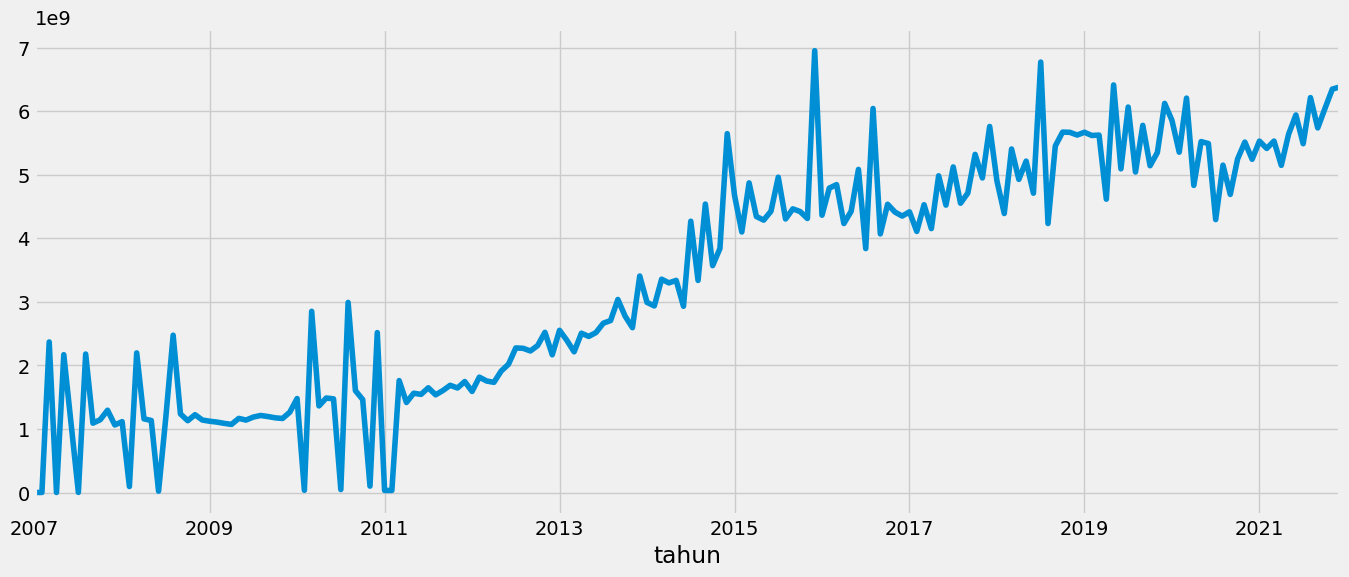

In [4]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [8]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(1, 1, 1), (0, 1, 1, 12), 7243.09192064552]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 1, 1),seasonal_order=(0, 1, 1, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3308.290
Date:                            Wed, 28 Dec 2022   AIC                           6624.579
Time:                                    08:17:15   BIC                           6636.701
Sample:                                01-01-2007   HQIC                          6629.503
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3961      0.148     -2.667      0.008      -0.687      -0.105
ma.L1         -0.6488      0.159   

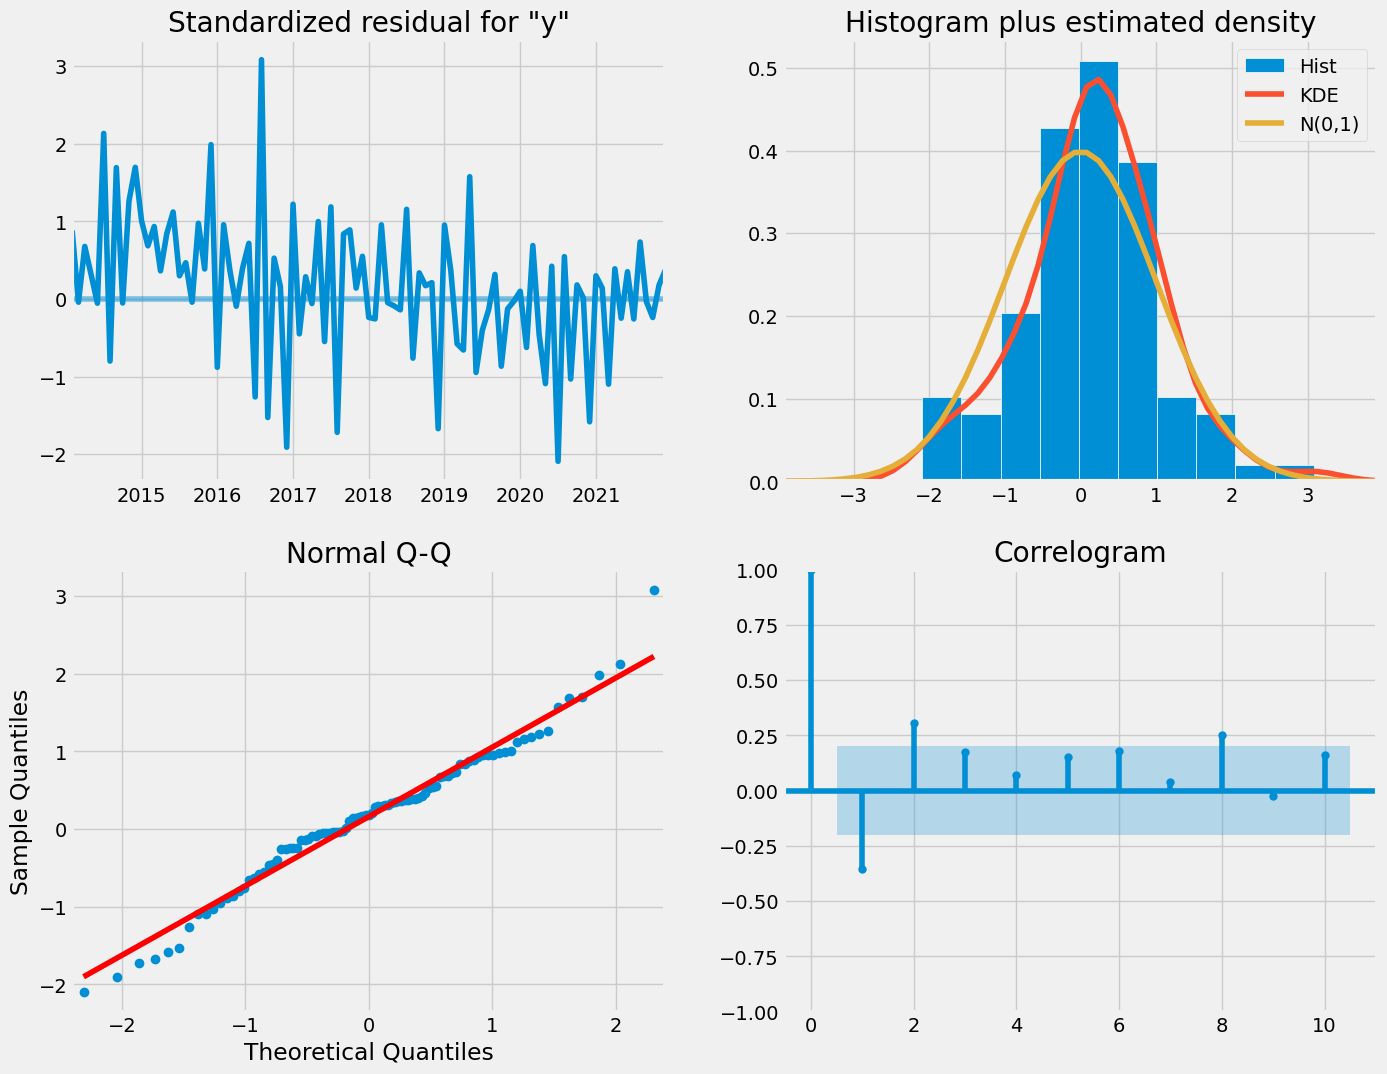

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

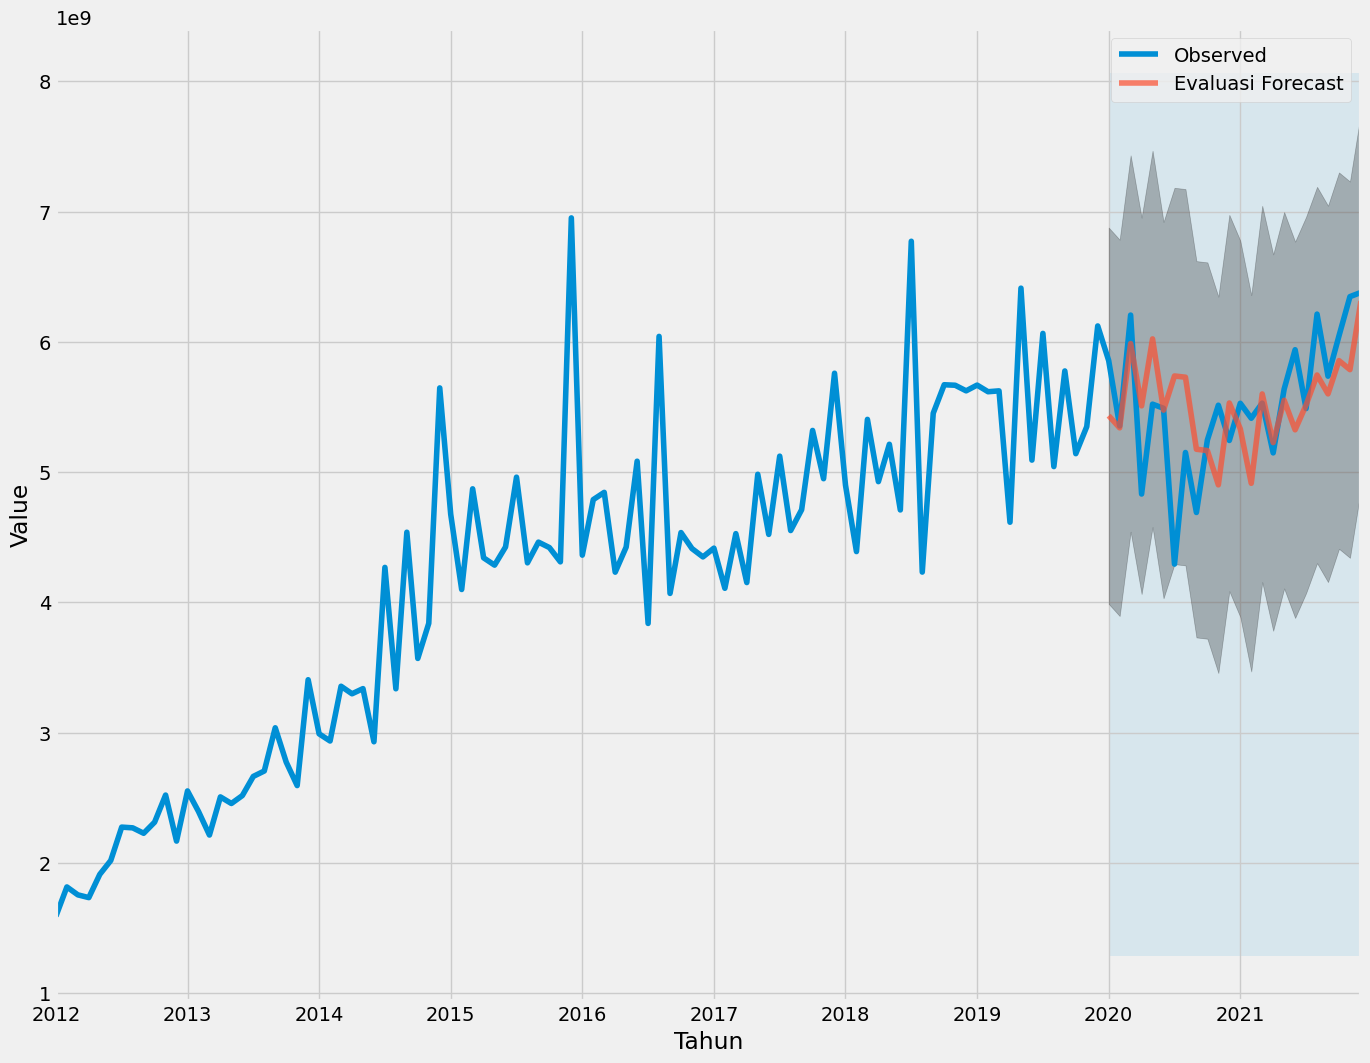

In [13]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [10]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/ppj_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":6158563159.0981531143,"2022-02-01T00:00:00.000":5910434385.8590831757,"2022-03-01T00:00:00.000":6433051629.8822231293,"2022-04-01T00:00:00.000":5919704769.518611908,"2022-05-01T00:00:00.000":6338633234.8159036636,"2022-06-01T00:00:00.000":6167809061.9453172684,"2022-07-01T00:00:00.000":6285691185.2607288361,"2022-08-01T00:00:00.000":6350271594.3925113678,"2022-09-01T00:00:00.000":6285219653.7802410126,"2022-10-01T00:00:00.000":6340499085.6330709457,"2022-11-01T00:00:00.000":6350280754.9232578278,"2022-12-01T00:00:00.000":6764350664.2726192474,"2023-01-01T00:00:00.000":6431048910.5082654953,"2023-02-01T00:00:00.000":6227513418.7945785522,"2023-03-01T00:00:00.000":6732468244.9529523849,"2023-04-01T00:00:00.000":6226117079.7738742828,"2023-05-01T00:00:00.000":6642274704.0974340439,"2023-06-01T00:00:00.000":6472548000.3845500946,"2023-07-01T00:00:00.000":6589995440.308339119,"2023-08-01T00:00:00.000":6654748017.9695301056,"2023-09-01T00:00:00.000":6589627885.1900

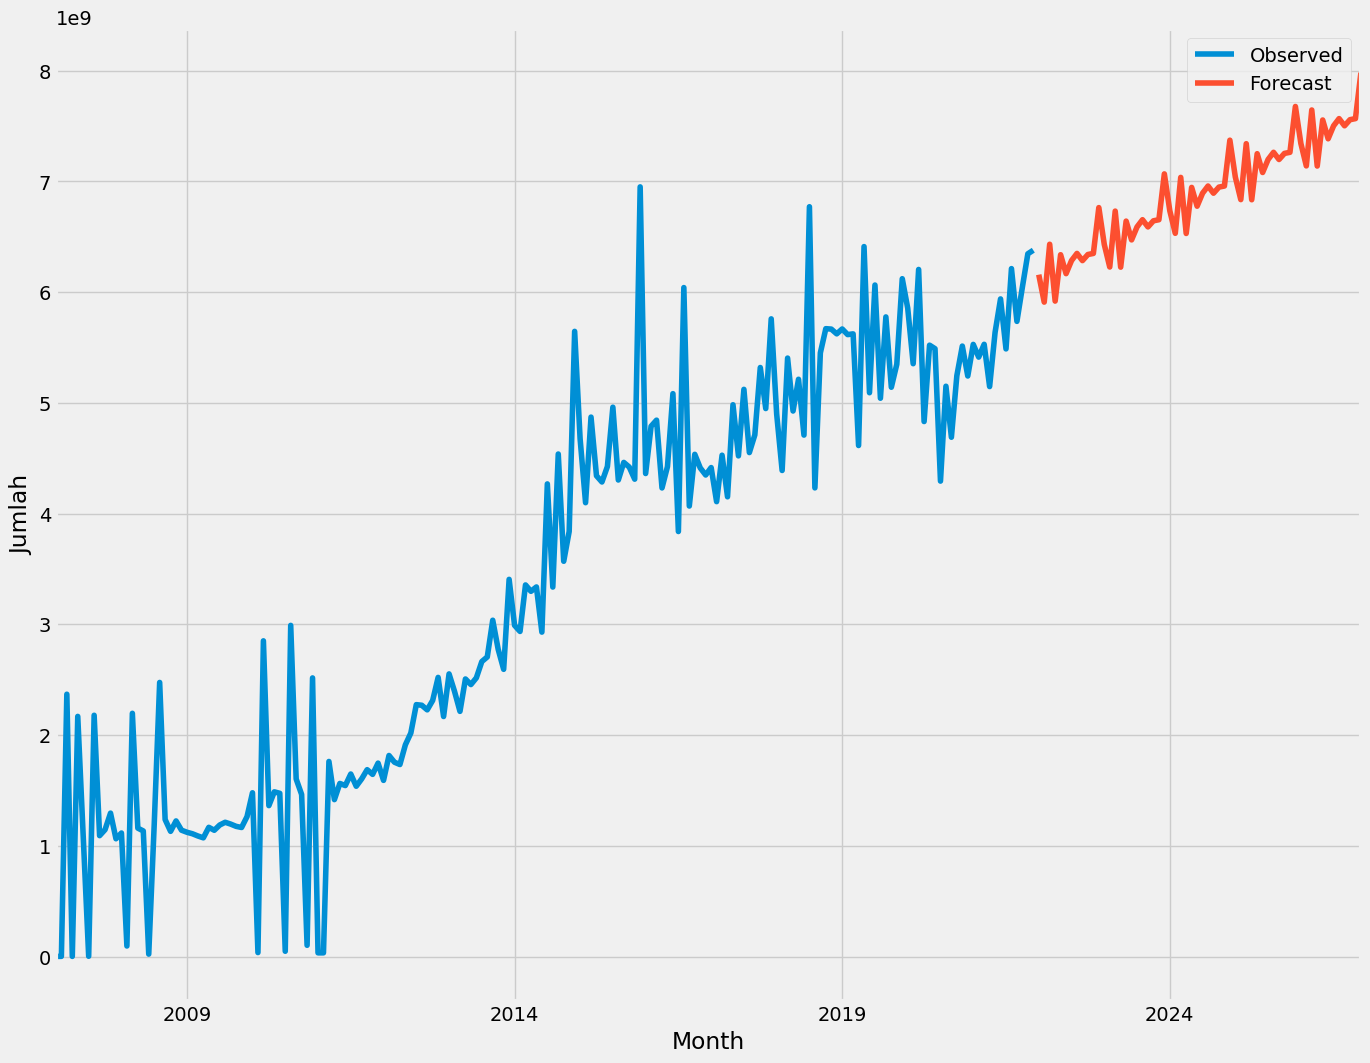

In [11]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()